In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [246]:
data = pd.read_excel('./OppScrData.xlsx', index_col=None)
data=data[data.columns[0:52]]
data.head()

,Record ID,Visit ID,PT ID,Clinical F/U interval [d from CT],BMI,BMI >30,Sex,Age at CT,Tobacco,Alcohol abuse,...,TAT Area (cm2),Total Body Area EA (cm2),VAT Area (cm2),SAT Area (cm2),VAT/SAT Ratio,Muscle HU,Muscle Area (cm2),L3 SMI (cm2/m2),AoCa Agatston,Liver HU (Median)
0,8675,415,6669,907,37.7,Y,Male,73,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18.242557,170.053192,58.717526,5473.561,35
1,2236,525,2915,359,30.1,Y,Female,55,NaN,NaN,...,485.502857,694.314286,183.497143,302.008571,0.607589,16.150123,123.968745,48.413187,2709.064,52
2,5962,542,5321,412,28.1,N,Female,52,NaN,NaN,...,490.054545,706.051515,159.706061,330.348485,0.483447,23.337964,136.566261,50.101332,0.000,54
3,665,546,1934,2333,25.0,N,Male,60,Yes,NaN,...,289.108108,584.489189,144.002703,145.102703,0.992419,30.804567,212.296726,69.115854,2586.575,57
4,478,580,1817,532,22.4,N,Male,88,Yes,NaN,...,315.530769,588.892308,202.317949,113.212821,1.787059,-3.181874,168.923950,47.814581,431.519,53


In [247]:
clinical_col=data.columns[0:14]
outcome_col=data.columns[15:40]
CT_col=data.columns[41:52]

In [248]:
CT_data=data[CT_col]
CT_data=CT_data.fillna(CT_data.mean())
CT_data['Liver HU    (Median)']=pd.to_numeric(CT_data['Liver HU    (Median)'],errors='coerce')

In [249]:
CT_data=CT_data.astype(float)

Fill blank with large number. First classify 'blank or not'.

In [250]:
blank=5000
data['DEATH [d from CT]']=data['DEATH [d from CT]'].fillna(blank)
death=data['DEATH [d from CT]']

In [251]:
X = CT_data.values
y = death.values

In [252]:
def KNN(train_X,train_y,test_x,K):
    dist=np.zeros(len(train_y))
    for i in range(len(train_y)):
        dist[i]=np.linalg.norm(test_x-train_X[i])
    dist_ind=dist.argsort()[0:K]
    y_lab=[]
    for i in range(K):
        y_lab.append(np.float64(train_y[dist_ind[i]]))
    return(y_lab)

In [253]:
training_X, testing_X, training_y, testing_y = train_test_split(X, y, test_size = 0.2)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_X = sc.fit_transform(training_X)
testing_X = sc.transform(testing_X)

In [254]:
y_pred=[]
y_lab=[]
num_na=[]
acc=[]
kk=20
for i in range(len(testing_y)):
    y_pred_all=KNN(training_X,training_y,testing_X[i],kk)
    y_pred.append(np.mean(y_pred_all))
    num_na.append((np.array(y_pred_all)==blank).sum())
    if num_na[i]>kk/2: y_pred[i]=blank
    y_lab.append(y_pred[i])
    acc.append(y_lab[i]-testing_y[i])
np.absolute(acc).sum()/len(testing_y)

172.4979403794038

blank=8000: mae=296
<br>blank=6000: mae=170
<br>blank=5000: mae=172

Without NA, 10-fold.

In [ ]:
death=death[death!=blank]
CT_data=CT_data.loc[data['DEATH [d from CT]']!=blank]
X = CT_data.values
y = death.values
## 10-fold validation
kacc=[]
num=len(y)//10
folds=[]
y_folds=[]
for i in range(10):
    foldi=X[(num*i):(num*i+num),:]
    y_foldi=y[(num*i):(num*i+num)]
    folds.append(foldi)
    y_folds.append(y_foldi) 
for kk in range(10,50):
    acc=[]
    for i in range(10):
        folds1=folds.copy()
        y_folds1=y_folds.copy()
        del folds1[i]
        del y_folds1[i]
        train_x=np.vstack(folds1)
        test_x=folds[i]
        test_y=y_folds[i]
        train_y=np.hstack(y_folds1)
        sc = MinMaxScaler()
        train_X = sc.fit_transform(train_x)
        test_X = sc.transform(test_x) 
        for j in range(len(test_y)):
            pred=np.mean(KNN(train_X,train_y,test_X[j],kk))
            acc.append(np.absolute(test_y[j]-pred))
    kacc.append(sum(acc)/len(test_y)/10)

In [ ]:
validate_X, test_X, validate_y, test_y = train_test_split(testing_X, testing_y, test_size = 0.)
mae=[]
for kk in range(10,100):    
    print(kk)
    y_pred=[]
    y_lab=[]
    num_na=[]
    acc=[]
    for i in range(len(validate_y)):
        y_pred_all=KNN(training_X,training_y,validate_X[i],kk)
        y_pred.append(np.mean(y_pred_all))
        #num_na.append((np.array(y_pred_all)==blank).sum())
        #if num_na[i]>kk/2: y_pred[i]=blank
        y_lab.append(y_pred[i])
        acc.append(y_lab[i]-validate_y[i])
    mae.append(np.absolute(acc).sum()/len(validate_y))


Text(0, 0.5, 'Mean Absolute Error')

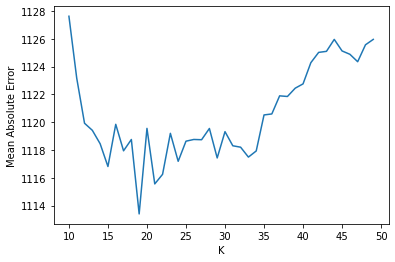

In [ ]:
plt.plot(range(10,50),kacc)
#plt.axhline(y=0.5, color='r', linestyle='-')
plt.xlabel('K')
plt.ylabel('Mean Absolute Error')